In [31]:
#import findspark
#findspark.init()
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql import Row
import pyspark.sql.functions as func
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012 Assignment 1 Task2") \
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

sc = spark.sparkContext

sc.setCheckpointDir('checkpoint/')

np.random.seed(1234)

In [2]:
def load_data(filepath):
    lines = spark.read.text(filepath).rdd
    parts = lines.map(lambda row: row.value.split(","))
    header = parts.first()
    parts = parts.filter(lambda line: line != header)
    return parts

ratingsRDD = load_data("ml-25m/ratings.csv").map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),rating=float(p[2]), timestamp=str(p[3])))
ratings = spark.createDataFrame(ratingsRDD).cache()

scoresRDD = load_data("ml-25m/genome-scores.csv").map(lambda p: Row(movieId=int(p[0]), tagId=int(p[1]),relevance=float(p[2])))
scores = spark.createDataFrame(scoresRDD).cache()

tagsRDD = load_data("ml-25m/genome-tags.csv").map(lambda p: Row(tagId=int(p[0]), tag=str(p[1])))
tags = spark.createDataFrame(tagsRDD).cache()

count_tagsRDD = load_data("ml-25m/tags.csv").map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),tag=str(p[2]), timestamp=str(p[3])))
count_tags = spark.createDataFrame(count_tagsRDD).cache()

In [3]:
(fold_0, fold_1, fold_2) = ratings.randomSplit([1.0, 1.0, 1.0],seed=1234)

data_list = [fold_0,fold_1,fold_2]
test_list = [fold_2,fold_0,fold_1]

In [4]:
als_1 = ALS(rank=10,maxIter=10, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
als_2 = ALS(rank=25, maxIter=50, regParam=0.05, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
als_3 = ALS(rank=50,maxIter=100, regParam=0.005, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

In [5]:
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating",predictionCol="prediction")

In [8]:
def cross_validate(als_version, req_itemFactor= False):
    
    if req_itemFactor == True:
        dfItemFactors_list = []
        
    rmse_list =[]
    mae_list =[]
    fold_j = 0
    for fold_i in range(len(data_list)):
        if fold_j < len(data_list)-1:
            fold_j+= 1
        else:
            fold_j = 0
        first_train = data_list[fold_i].union(data_list[fold_j])
        model = als_version.fit(first_train)
        predictions = model.transform(test_list[fold_i])
        
        rmse = rmse_evaluator.evaluate(predictions)
        mae = mae_evaluator.evaluate(predictions)
        rmse_list.append(rmse)
        mae_list.append(mae)
        
        if req_itemFactor == True:
            dfItemFactors=model.itemFactors
            dfItemFactors_list.append(dfItemFactors)
            
    if req_itemFactor == True:
        return dfItemFactors_list,rmse_list, mae_list
    else:
        return rmse_list, mae_list

In [9]:
ItemFactors_list, rmse_als_1, mae_als_1 = cross_validate(als_1, req_itemFactor= True)

In [10]:
rmse_als_2, mae_als_2 = cross_validate(als_2)

In [11]:
rmse_als_3, mae_als_3 = cross_validate(als_3)

In [12]:
import statistics as stat

In [13]:
#for calculate std and mean for rmse metric
als1_rmse_std,als1_rmse_mean = stat.stdev(rmse_als_1),stat.mean(rmse_als_1)
als2_rmse_std,als2_rmse_mean = stat.stdev(rmse_als_2),stat.mean(rmse_als_2)
als3_rmse_std,als3_rmse_mean = stat.stdev(rmse_als_3),stat.mean(rmse_als_3)

#for calculate std and mean for mae metric
als1_mae_std,als1_mae_mean = stat.stdev(mae_als_1),stat.mean(mae_als_1)
als2_mae_std,als2_mae_mean = stat.stdev(mae_als_2),stat.mean(mae_als_2)
als3_mae_std,als3_mae_mean = stat.stdev(mae_als_3),stat.mean(mae_als_3)

In [21]:
rdd_report = sc.parallelize([(rmse_als_1[0],mae_als_1[0],rmse_als_2[0],mae_als_2[0],rmse_als_3[0],mae_als_3[0]),
                            (rmse_als_1[1],mae_als_1[1],rmse_als_2[1],mae_als_2[1],rmse_als_3[1],mae_als_3[1]),
                            (rmse_als_1[2],mae_als_1[2],rmse_als_2[2],mae_als_2[2],rmse_als_3[2],mae_als_3[2]),
                            (als1_rmse_std,als1_mae_std,als2_rmse_std,als2_mae_std,als3_rmse_std,als3_mae_std),
                            (als1_rmse_mean,als1_mae_mean,als2_rmse_mean,als2_mae_mean,als3_rmse_mean,als3_mae_mean)])

In [27]:
df_report = rdd_report.toDF(['ALS Version 1 RMSE Result','ALS Version 1 MAE Result'
                             ,'ALS Version 2 RMSE Result','ALS Version 2 MAE Result'
                            ,'ALS Version 3 RMSE Result','ALS Version 3 MAE Result'])

df_pd = df_report.toPandas()

In [28]:
df_pd.index = ['Fold1','Fold2','Fold3','Std','Mean']

In [29]:
print(df_pd)
df_report.toPandas().to_csv('Q2A_result.csv')

       ALS Version 1 RMSE Result  ALS Version 1 MAE Result  \
Fold1                   0.808007                  0.625098   
Fold2                   0.808036                  0.625095   
Fold3                   0.808094                  0.625160   
Std                     0.000044                  0.000037   
Mean                    0.808046                  0.625117   

       ALS Version 2 RMSE Result  ALS Version 2 MAE Result  \
Fold1                   0.774799                  0.589960   
Fold2                   0.775085                  0.590176   
Fold3                   0.774869                  0.589928   
Std                     0.000149                  0.000135   
Mean                    0.774918                  0.590021   

       ALS Version 3 RMSE Result  ALS Version 3 MAE Result  
Fold1                   0.910647                  0.674255  
Fold2                   0.910537                  0.674191  
Fold3                   0.910563                  0.674222  
Std       

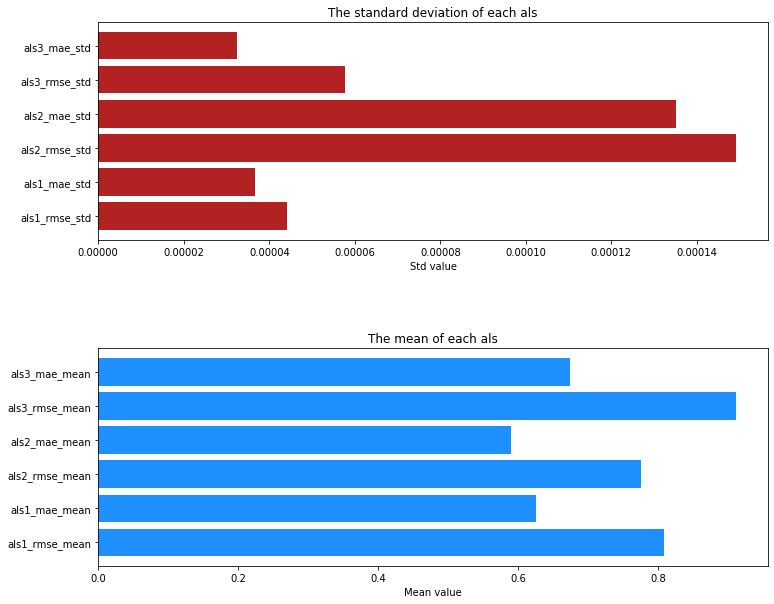

In [33]:
std_list=[als1_rmse_std,als1_mae_std,als2_rmse_std,als2_mae_std,als3_rmse_std,als3_mae_std]
mean_list =[als1_rmse_mean,als1_mae_mean,als2_rmse_mean,als2_mae_mean,als3_rmse_mean,als3_mae_mean]

x = np.arange(6)
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.yticks(np.arange(6), ('als1_rmse_std','als1_mae_std','als2_rmse_std','als2_mae_std','als3_rmse_std','als3_mae_std'))
plt.title("The standard deviation of each als")
plt.xlabel("Std value")
plt.barh(np.array(x),np.array(std_list),color=['firebrick'])
plt.subplots_adjust(hspace = 0.5)

plt.subplot(212)
plt.yticks(np.arange(6), ('als1_rmse_mean','als1_mae_mean','als2_rmse_mean','als2_mae_mean','als3_rmse_mean','als3_mae_mean'))
plt.title("The mean of each als")
plt.xlabel("Mean value")
plt.barh(np.array(x),np.array(mean_list),color=['dodgerblue'])
plt.savefig('Q2A_FIG1')

In [34]:
from pyspark.ml.linalg import Vectors
def transData(data):
    return data.rdd.map(lambda r: [r[0],Vectors.dense(r[1])]).toDF(['movieId','features'])
                                                                   
df_1_vec= transData(ItemFactors_list[0])
df_2_vec= transData(ItemFactors_list[1])
df_3_vec= transData(ItemFactors_list[2])

In [35]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(25).setSeed(1234)
model_1= kmeans.fit(df_1_vec)
model_2= kmeans.fit(df_2_vec)
model_3= kmeans.fit(df_3_vec)
predictions_1 = model_1.transform(df_1_vec)
predictions_2 = model_2.transform(df_2_vec)
predictions_3 = model_3.transform(df_3_vec)

movieid_cluster_1 = predictions_1.drop('features')
movieid_cluster_2 = predictions_2.drop('features')
movieid_cluster_3 = predictions_3.drop('features')

largest_cluster_1 = predictions_1.groupBy('prediction').count().sort('count', ascending=False).limit(3)
largest_cluster_2 = predictions_2.groupBy('prediction').count().sort('count', ascending=False).limit(3)
largest_cluster_3 = predictions_3.groupBy('prediction').count().sort('count', ascending=False).limit(3)

In [36]:
print("First Split:")
largest_cluster_1.show()
print("Second Split:")
largest_cluster_2.show()
print("Third Split:")
largest_cluster_3.show()

First Split:
+----------+-----+
|prediction|count|
+----------+-----+
|        13| 5452|
|        16| 3748|
|        10| 3596|
+----------+-----+

Second Split:
+----------+-----+
|prediction|count|
+----------+-----+
|         0| 4569|
|        13| 4381|
|         1| 3803|
+----------+-----+

Third Split:
+----------+-----+
|prediction|count|
+----------+-----+
|        24| 4621|
|         1| 4402|
|        12| 3326|
+----------+-----+



In [37]:
#getting dataset 
first_cluster_1 = movieid_cluster_1.filter(movieid_cluster_1['prediction']== largest_cluster_1.collect()[0][0])
second_cluster_1 = movieid_cluster_1.filter(movieid_cluster_1['prediction']== largest_cluster_1.collect()[1][0])
third_cluster_1 = movieid_cluster_1.filter(movieid_cluster_1['prediction']== largest_cluster_1.collect()[2][0])

first_cluster_2 = movieid_cluster_2.filter(movieid_cluster_2['prediction']==largest_cluster_2.collect()[0][0])
second_cluster_2 = movieid_cluster_2.filter(movieid_cluster_2['prediction']==largest_cluster_2.collect()[1][0])
third_cluster_2 = movieid_cluster_2.filter(movieid_cluster_2['prediction']==largest_cluster_2.collect()[2][0])

first_cluster_3 = movieid_cluster_3.filter(movieid_cluster_3['prediction']==largest_cluster_3.collect()[0][0])
second_cluster_3 = movieid_cluster_3.filter(movieid_cluster_3['prediction']==largest_cluster_3.collect()[1][0])
third_cluster_3 = movieid_cluster_3.filter(movieid_cluster_3['prediction']==largest_cluster_3.collect()[2][0])

In [38]:
#use inner join to have all the tags for the movies in the cluster 
first_cluster_scores_1 = first_cluster_1.join(scores, on=['movieId'], how='inner')
second_cluster_scores_1 = second_cluster_1.join(scores, on=['movieId'], how='inner')
third_cluster_scores_1 = third_cluster_1.join(scores, on=['movieId'], how='inner')

first_cluster_scores_2 = first_cluster_2.join(scores, on=['movieId'], how='inner')
second_cluster_scores_2 = second_cluster_2.join(scores, on=['movieId'], how='inner')
third_cluster_scores_2 = third_cluster_2.join(scores, on=['movieId'], how='inner')

first_cluster_scores_3 = first_cluster_3.join(scores, on=['movieId'], how='inner')
second_cluster_scores_3 = second_cluster_3.join(scores, on=['movieId'], how='inner')
third_cluster_scores_3 = third_cluster_3.join(scores, on=['movieId'], how='inner')

In [39]:
#find the top 3 tags by adding all the scores, fc,sc,tc refer to first,second,third clusters.
largest_tags_fc_1 = first_cluster_scores_1.groupBy('tagId').agg(func.sum('relevance'))
largest_tags_fc_2 = second_cluster_scores_1.groupBy('tagId').agg(func.sum('relevance'))
largest_tags_fc_3 = third_cluster_scores_1.groupBy('tagId').agg(func.sum('relevance'))

largest_tags_sc_1 = first_cluster_scores_2.groupBy('tagId').agg(func.sum('relevance'))
largest_tags_sc_2 = second_cluster_scores_2.groupBy('tagId').agg(func.sum('relevance'))
largest_tags_sc_3 = third_cluster_scores_2.groupBy('tagId').agg(func.sum('relevance'))

largest_tags_tc_1  = first_cluster_scores_3.groupBy('tagId').agg(func.sum('relevance'))
largest_tags_tc_2 = second_cluster_scores_3.groupBy('tagId').agg(func.sum('relevance'))
largest_tags_tc_3 = third_cluster_scores_3.groupBy('tagId').agg(func.sum('relevance'))

In [40]:
tags_fc_1 = largest_tags_fc_1.sort('sum(relevance)', ascending=False).limit(3)
tags_fc_2 = largest_tags_fc_2.sort('sum(relevance)', ascending=False).limit(3)
tags_fc_3 = largest_tags_fc_3.sort('sum(relevance)', ascending=False).limit(3)

tags_sc_1 = largest_tags_sc_1.sort('sum(relevance)', ascending=False).limit(3)
tags_sc_2 = largest_tags_sc_2.sort('sum(relevance)', ascending=False).limit(3)
tags_sc_3 = largest_tags_sc_3.sort('sum(relevance)', ascending=False).limit(3)

tags_tc_1 = largest_tags_tc_1.sort('sum(relevance)', ascending=False).limit(3)
tags_tc_2 = largest_tags_tc_2.sort('sum(relevance)', ascending=False).limit(3)
tags_tc_3 = largest_tags_tc_3.sort('sum(relevance)', ascending=False).limit(3)

In [41]:
print("---------------------TOP 3 Tag for each cluster and split------------------------")
print("---------------------First Split First Cluster------------------------")
tag_1 = tags.filter(tags['tagId']== tags_fc_1.collect()[0][0])
tag_1.show()
tag_1_count = count_tags.filter(count_tags['tag']==tag_1.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_1_count)

tag_2 = tags.filter(tags['tagId']== tags_fc_1.collect()[1][0])
tag_2.show()
tag_2_count = count_tags.filter(count_tags['tag']==tag_2.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_2_count)

tag_3 = tags.filter(tags['tagId']== tags_fc_1.collect()[2][0])
tag_3.show()
tag_3_count = count_tags.filter(count_tags['tag']==tag_3.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_3_count)

print("---------------------First Split Second Cluster------------------------")
tag_4 = tags.filter(tags['tagId']== tags_sc_1.collect()[0][0])
tag_4.show()
tag_4_count = count_tags.filter(count_tags['tag']==tag_4.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_4_count)

tag_5 = tags.filter(tags['tagId']== tags_sc_1.collect()[1][0])
tag_5.show()
tag_5_count = count_tags.filter(count_tags['tag']==tag_5.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_5_count)

tag_6 = tags.filter(tags['tagId']== tags_sc_1.collect()[2][0])
tag_6.show()
tag_6_count = count_tags.filter(count_tags['tag']==tag_6.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_6_count)

print("---------------------First Split Third Cluster------------------------")
tag_7 = tags.filter(tags['tagId']== tags_tc_1.collect()[0][0])
tag_7.show()
tag_7_count = count_tags.filter(count_tags['tag']==tag_7.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_7_count)

tag_8 = tags.filter(tags['tagId']== tags_tc_1.collect()[1][0])
tag_8.show()
tag_8_count = count_tags.filter(count_tags['tag']==tag_8.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_8_count)

tag_9 = tags.filter(tags['tagId']== tags_tc_1.collect()[2][0])
tag_9.show()
tag_9_count = count_tags.filter(count_tags['tag']==tag_9.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_9_count)

print("---------------------Second Split First Cluster------------------------")
tag_10 = tags.filter(tags['tagId']== tags_fc_2.collect()[0][0])
tag_10.show()
tag_10_count = count_tags.filter(count_tags['tag']==tag_10.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_10_count)

tag_11 = tags.filter(tags['tagId']== tags_fc_2.collect()[1][0])
tag_11.show()
tag_11_count = count_tags.filter(count_tags['tag']==tag_11.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_11_count)

tag_12 = tags.filter(tags['tagId']== tags_fc_2.collect()[2][0])
tag_12.show()
tag_12_count = count_tags.filter(count_tags['tag']==tag_12.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_12_count)

print("---------------------Second Split Second Cluster------------------------")
tag_13 = tags.filter(tags['tagId']== tags_sc_2.collect()[0][0])
tag_13.show()
tag_13_count = count_tags.filter(count_tags['tag']==tag_13.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_13_count)

tag_14 = tags.filter(tags['tagId']== tags_sc_2.collect()[1][0])
tag_14.show()
tag_14_count = count_tags.filter(count_tags['tag']==tag_14.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_14_count)

tag_15 = tags.filter(tags['tagId']== tags_sc_2.collect()[2][0])
tag_15.show()
tag_15_count = count_tags.filter(count_tags['tag']==tag_15.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_15_count)

print("---------------------Second Split Third Cluster------------------------")
tag_16 = tags.filter(tags['tagId']== tags_tc_2.collect()[0][0])
tag_16.show()
tag_16_count = count_tags.filter(count_tags['tag']==tag_16.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_16_count)

tag_17 = tags.filter(tags['tagId']== tags_tc_2.collect()[1][0])
tag_17.show()
tag_17_count = count_tags.filter(count_tags['tag']==tag_17.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_17_count)

tag_18 = tags.filter(tags['tagId']== tags_tc_2.collect()[2][0])
tag_18.show()
tag_18_count = count_tags.filter(count_tags['tag']==tag_18.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_18_count)

print("---------------------Third Split First Cluster------------------------")
tag_19 = tags.filter(tags['tagId']== tags_fc_3.collect()[0][0])
tag_19.show()
tag_19_count = count_tags.filter(count_tags['tag']==tag_19.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_19_count)

tag_20 = tags.filter(tags['tagId']== tags_fc_3.collect()[1][0])
tag_20.show()
tag_20_count = count_tags.filter(count_tags['tag']==tag_20.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_20_count)

tag_21 = tags.filter(tags['tagId']== tags_fc_3.collect()[2][0])
tag_21.show()
tag_21_count = count_tags.filter(count_tags['tag']==tag_21.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_21_count)

print("---------------------Third Split Second Cluster------------------------")
tag_22 = tags.filter(tags['tagId']== tags_sc_3.collect()[0][0])
tag_22.show()
tag_22_count = count_tags.filter(count_tags['tag']==tag_22.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_22_count)

tag_23 = tags.filter(tags['tagId']== tags_sc_3.collect()[1][0])
tag_23.show()
tag_23_count = count_tags.filter(count_tags['tag']==tag_23.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_23_count)

tag_24 = tags.filter(tags['tagId']== tags_sc_3.collect()[2][0])
tag_24.show()
tag_24_count = count_tags.filter(count_tags['tag']==tag_24.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_24_count)

print("---------------------Third Split Third Cluster------------------------")
tag_25 = tags.filter(tags['tagId']== tags_tc_3.collect()[0][0])
tag_25.show()
tag_25_count = count_tags.filter(count_tags['tag']==tag_25.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_25_count)

tag_26 = tags.filter(tags['tagId']== tags_tc_3.collect()[1][0])
tag_26.show()
tag_26_count = count_tags.filter(count_tags['tag']==tag_26.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_26_count)

tag_27 = tags.filter(tags['tagId']== tags_tc_3.collect()[2][0])
tag_27.show()
tag_27_count = count_tags.filter(count_tags['tag']==tag_27.collect()[0][0]).count()
print('Respective Number of movies having the tags:',tag_27_count)

---------------------TOP 3 Tag for each cluster and split------------------------
---------------------First Split First Cluster------------------------
+--------+-----+
|     tag|tagId|
+--------+-----+
|original|  742|
+--------+-----+

Respective Number of movies having the tags: 1077
+------+-----+
|   tag|tagId|
+------+-----+
|mentor|  646|
+------+-----+

Respective Number of movies having the tags: 312
+------------+-----+
|         tag|tagId|
+------------+-----+
|great ending|  468|
+------------+-----+

Respective Number of movies having the tags: 846
---------------------First Split Second Cluster------------------------
+--------+-----+
|     tag|tagId|
+--------+-----+
|original|  742|
+--------+-----+

Respective Number of movies having the tags: 1077
+------+-----+
|   tag|tagId|
+------+-----+
|mentor|  646|
+------+-----+

Respective Number of movies having the tags: 312
+------------+-----+
|         tag|tagId|
+------------+-----+
|great ending|  468|
+------------+

In [42]:
tag_report = sc.parallelize([(tag_1_count,tag_2_count,tag_3_count,\
                             tag_4_count,tag_5_count,tag_6_count,\
                            tag_7_count,tag_8_count,tag_9_count,\
                             tag_10_count,tag_11_count,tag_12_count,\
                            tag_13_count,tag_14_count,tag_15_count,\
                             tag_16_count,tag_17_count,tag_18_count,\
                            tag_19_count,tag_20_count,tag_21_count,\
                             tag_22_count,tag_23_count,tag_24_count,\
                            tag_25_count,tag_26_count,tag_27_count)])
df_tag_report = tag_report.toDF([tag_1.collect()[0][0],tag_2.collect()[0][0],tag_3.collect()[0][0],tag_4.collect()[0][0],tag_5.collect()[0][0],tag_6.collect()[0][0],\
                            tag_7.collect()[0][0],tag_8.collect()[0][0],tag_9.collect()[0][0],tag_10.collect()[0][0],tag_11.collect()[0][0],tag_12.collect()[0][0],\
                            tag_13.collect()[0][0],tag_14.collect()[0][0],tag_15.collect()[0][0],tag_16.collect()[0][0],tag_17.collect()[0][0],tag_18.collect()[0][0],\
                            tag_19.collect()[0][0],tag_20.collect()[0][0],tag_21.collect()[0][0],tag_22.collect()[0][0],tag_23.collect()[0][0],tag_24.collect()[0][0],\
                            tag_25.collect()[0][0],tag_26.collect()[0][0],tag_27.collect()[0][0]])


df_tag_report_pd = df_tag_report.toPandas()
df_tag_report_pd.index = ['count']
print(df_tag_report_pd)
df_tag_report_pd.to_csv('tags_count')

       original  mentor  great ending  original  mentor  great ending  \
count      1077     312           846      1077     312           846   

       original  mentor  good  original  ...  storytelling  original  \
count      1077     312    60      1077  ...           464      1077   

       predictable  mentor  original  predictable  chase  original  \
count         2278     312      1077         2278    308      1077   

       predictable  mentor  
count         2278     312  

[1 rows x 27 columns]
